<h1 style="text-align: center;"> After applying of post-processing we need to obtain the optimal MF(median filter) size and threshold. This file contains functions related to this task. 
    <h2 style="text-align: center;"> <b>"Impact of Pre- and Post-Processing Steps for Supervised Classification of Colorectal Cancer in Hyperspectral Images" </b> </h2>
</h1> 
<h3>
    Paper: <a href='https://www.mdpi.com/2233040'>https://www.mdpi.com/2233040 </a> <br>
    Documentation: <a href='https://git.iccas.de/MaktabiM/hsi-experiments/-/wikis/Post-processing'>https://git.iccas.de/MaktabiM/hsi-experiments/-/wikis/Post-processing </a> <br> <br>
    
    The notebook is divided into sections for simplicity
</h3>

<h1 style="text-align: center;"> Part 1. Getting of the optimal parameters (MF size, threshold) and corresponding improvements for models </h1>

In [1]:
# With all these commands I tried to turn on 3d plots on cluster, but nothing worked
# 3d plots work only locally  

#!pip install --user --upgrade ipywidgets
#%matplotlib widget
#!jupyter  labextension install jupyter-matplotlib
#!pip install --user --upgrade ipyvolume==0.6.0a6
#!pip install --user --upgrade bqplot
#!jupyter labextension install --user bqplot

In [2]:
import csv
import numpy as np
import ipyvolume as ipv
from scipy.interpolate import griddata
import os

ModuleNotFoundError: No module named 'ipyvolume'

In [2]:
from evaluation.validator import Validator

paths from config ['/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/util', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/data_utils/data_loaders', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/models', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/trainers', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/data_utils', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments', '/software/jupyterlab/opt/anaconda3/envs/tensorflow/lib/python38.zip', '/software/jupyterlab/opt/anaconda3/envs/tensorflow/lib/python3.8', '/software/jupyterlab/opt/anaconda3/envs/tensorflow/lib/python3.8/lib-dynload', '', '/home/sc.uni-leipzig.de/mi186veva/.local/lib/python3.8/site-packages', '/software/jupyterlab/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages']
FILES_TO_COPY ['/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/utils.py', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/cross_validation_step.py', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/cross_validation.py', '/

In [3]:
class Plot3d:
    def __init__(self, home, model, best_threshold=None):
        path = os.path.join(home, model)
        validator = Validator(path, prints=False)
        
        if best_threshold is None:
            best_threshold, _, _, means, _ = validator.find_best_threshold_in_checkpoint(path)
            
        else:
            se, sp, means, _ = validator.get_values_by_threshold(path, best_threshold)
            print('Sens, spec:', se, sp)
        self.best_threshold = best_threshold
        
        print("Best threshold", best_threshold)
        #print(means)
        #print(best_sens, best_spec)
        if type(means) != list:
            means = [means]
            
        self.means = means
        
        self.plot_3d_intersections(os.path.join(path, 'compare_all_thresholds_filtered_AP.csv'))
    
    def get_X_Y_Z_original(self, medians):

        X_raw = self.best_threshold * np.ones(medians.shape[0])
        Y_raw = medians
        Z_raw = self.means[0] * np.ones(medians.shape[0])
        #Z_raw = [means] * np.ones(medians.shape[0])

        return X_raw, Y_raw, Z_raw

    def plot_3d_intersections(self, path):
        with open(path, newline='') as csvfile:
            report_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
            next(report_reader)
            data = []
            for row in report_reader:
                data.append(row)

        data = np.array(data)

        thresholds = data[:, 2].astype(float)
        medians = data[thresholds > 0, -1].astype(float)
        sens = data[thresholds > 0, 3].astype(float)
        spec = data[thresholds > 0, 4].astype(float)
        self.sens = sens
        self.spec = spec
        self.medians = medians
        thresholds = thresholds[thresholds > 0]
        self.thresholds = thresholds
        print('Thresholds:', np.unique(self.thresholds))
        print('Medians:', np.unique(self.medians))
        
        X_o, Y_o, Z_o = self.get_X_Y_Z_original(np.unique(medians))

        xv = np.linspace(min(thresholds), max(thresholds), 100);
        yv = np.linspace(min(medians), max(medians), 100);

        [X,Y] = np.meshgrid(xv, yv)

        Z_sens = griddata((thresholds,medians),sens,(X,Y), method='linear')
        Z_spec = griddata((thresholds,medians),spec,(X,Y), method='linear')
        Z_baseline = griddata((thresholds,medians), self.means[0] * np.ones(sens.shape[0]),(X,Y), method='linear')

        ipv.xlim(xmin=np.min(X), xmax=np.max(X))
        ipv.ylim(ymin=np.min(Y), ymax=np.max(Y))
        ipv.zlim(zmin=min(np.min(Z_spec), np.min(Z_sens)), zmax=max(np.max(Z_spec), np.max(Z_sens)))
        ipv.plot_surface(X, Y, Z_spec, color='blue')
        ipv.plot_surface(X, Y, Z_sens)
        ipv.plot_surface(X, Y, Z_baseline, color='green')
        #ipv.show()
        ipv.clear()
        
    def best_results(self, compare_integers=True):
        def print_best_results(text, prints=False):
            summ_ = sens_more + spec_more - (2 * self.means[0])
            summ_i = np.argmax(summ_)
            print('Means', self.means)
            print(f'=======Best values ({text})=======')
            print(f'Sensitivity: {sens_more[summ_i]}')
            print(f'Specificity: {spec_more[summ_i]}')
            print(f'Threshold: {thresholds_more[summ_i]}')
            print(f'Median: {medians_more[summ_i]}')
            print(f'Improvement total: {summ_[summ_i]}')
            print(f'Improvement sensitivity: {sens_more[summ_i] - self.means[0]}')
            print(f'Improvement specificity: {spec_more[summ_i] - self.means[0]}')
            ''' print(text + '(sens, spec, threshold, median, impovement summ, improvement sens, improvement spec)', 
                  sens_more[summ_i], 
                  spec_more[summ_i], 
                  thresholds_more[summ_i], 
                  medians_more[summ_i], 
                  summ_[summ_i], 
                  sens_more[summ_i] - self.means[0], 
                  spec_more[summ_i] - self.means[0])'''
            print('===================================')
            
            if prints:
                for se, sp, th, med, s in zip(sens_more, spec_more, thresholds_more, medians_more, summ_):
                    print(se, sp, th, med, s, se-self.means[0], sp-self.means[0])
        condition = (self.sens > self.means[0]) & (self.spec > self.means[0])
        sens_more = self.sens[condition] 
        spec_more = self.spec[condition] 
        thresholds_more = self.thresholds[condition]
        medians_more = self.medians[condition]

        
        print_best_results('With best improvement')
        if compare_integers:
            sens_more = np.round(sens_more, decimals=2)
            spec_more = np.round(spec_more, decimals=2)
            
            print_best_results('Integers with best improvement')


In [7]:
#C:\\Users\\tkachenko\\Desktop\\HSI\\paper post-processing\\results\\
#validator = Validator('test/CV_3d_inception')
#best_threshold, best_sens, best_spec, means, idx = validator.find_best_threshold_in_checkpoint('test/CV_3d_inception/cp-l2_norm_0036')
#validator = Validator('test/Colon_MedianFilter')
#best_threshold, best_sens, best_spec, means, idx = validator.find_best_threshold_in_checkpoint('test/Colon_MedianFilter/cp-0000')


#home = 'C:\\Users\\tkachenko\\Desktop\\HSI\\paper post-processing\\results\\'
home = '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/test/'

for model, threshold in zip(['CV_3d_inception/cp-l2_norm_0036/',
            'CV_3d_inception_exclude1_all/cp-svn_T_0016/',
            'CV_3d_inception_svn_every_third/cp-svn_T_0018/',
            'CV_3d_svn_every_third/cp-svn_T_0016/',
            'CV_3d_sample_weights_every_third/cp-svn_T_0018/',
            'CV_3d_every_third/cp-l2_norm_0016/',
            'CV_3d_inception_exclude1_every_third/cp-svn_T_0016/',
            ],
                [0.2111,
                 0.0189, 
                 0.0456,
                 0.0367, 
                 0.45,
                 0.1556, 
                 0.0456
            ]):
    print(model)
    plt_3d = Plot3d(home, model, best_threshold=threshold)
    plt_3d.best_results(compare_integers=False)
    print('-------------------------------------------------------------------------------')
    #plt_3d.best_results()

CV_3d_inception/cp-l2_norm_0036/
Sens, spec: [0.89089346] [0.8946168]
Best threshold 0.2111
Thresholds: [0.1056 0.1167 0.1278 0.1389 0.15   0.1611 0.1722 0.1833 0.1944 0.2055
 0.2111 0.2167 0.2222 0.2278 0.2333 0.2389 0.2444 0.25   0.2555 0.2611
 0.2667 0.2722 0.2778 0.2833 0.2889 0.2944 0.3    0.3055 0.3111 0.3166
 0.3222 0.3278 0.3333 0.3444 0.3555 0.3611 0.3666 0.3778 0.3889 0.3944
 0.4    0.4111 0.4222 0.4278 0.4444 0.4611 0.4778 0.4944 0.5111 0.5277]
Medians: [ 5. 11. 15. 21. 25. 31. 35. 41. 45. 51. 55. 61.]
Means [0.89275515]
=======Best values (With best improvement)=======
Sensitivity: 0.9145536150325667
Specificity: 0.9373512080829648
Threshold: 0.3333
Median: 51.0
Improvement total: 0.06639452152556569
Improvement sensitivity: 0.021798464237583803
Improvement specificity: 0.04459605728798188
-------------------------------------------------------------------------------
CV_3d_inception_exclude1_all/cp-svn_T_0016/
Sens, spec: [0.8851445] [0.88187224]
Best threshold 0.0189
Thre

<h1 style="text-align: center;">Part 2. Research about automatic ranges detection (ranges for MF sizes and thresholds) </h1> 
is not fihished and probably doesn't work, because Plot3d class was created  

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
sens_v = np.linspace(min(sens), max(sens), 100)
spec_v = np.linspace(min(spec), max(spec), 100)

[X,Y] = np.meshgrid(xv, sens_v)
    
Z_sens = griddata((thresholds,medians),sens,(X,Y), method='linear')
Z_spec = griddata((thresholds,medians),spec,(X,Y), method='linear')

[[-0.03934341 -0.03771663 -0.03608985 ...         nan         nan
          nan]
 [-0.03929206 -0.03778838 -0.03616161 ...         nan         nan
          nan]
 [-0.03924072 -0.03782213 -0.03623336 ...         nan         nan
          nan]
 ...
 [        nan         nan         nan ...  0.03824596  0.03886385
   0.03946124]
 [        nan         nan         nan ...  0.03826864  0.03890581
   0.03951344]
 [        nan         nan         nan ...  0.03829132  0.03892848
   0.03956565]]


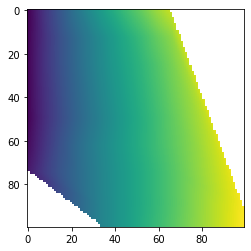

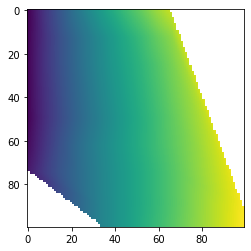


[-1.  1. nan ... nan nan nan]


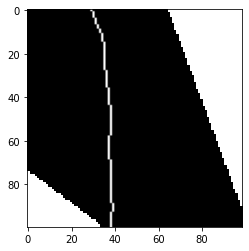

In [46]:
#show intersection between surfaces of sens and spec
# -> it will (probably) help us to automaticly understand what ranges to try
# probably this part doesn't work, becausse previous two cells were updated
# -> probably we need to hide this part inside Plot3d class

Z_diff = Z_spec - Z_sens

ipv.plot_surface(X, Y, Z_diff, color='yellow')
ipv.show()
ipv.clear()


print(Z_diff)

plt.imshow(Z_diff)
plt.show()

plt.imshow(Z_diff)
plt.show()

print()

plt.imshow(np.sign(Z_diff), cmap='gray')
plt.imshow(np.diff(np.sign(Z_diff)), cmap='gray')

print(np.unique(np.sign(Z_diff)))

<h1 style="text-align: center;">Part 3. Getting of all improvements for one model that fits condition that new (with post-rpocessing) sens and spec are higher then old sens and spec (before post-processing) </h1>
probably doesn't work, because Plot3d class was created (we need to hide it inside it)

In [2]:
from IPython.display import display
import pandas as pd

In [1]:
#print best improvements for one model

condition = (sens > means[0]) & (spec > means[0])
sens_more = sens[condition] 
spec_more = spec[condition] 
thresholds_more = thresholds[condition]
medians_more = medians[condition]

improvement_ = sens_more + spec_more - (2 * means[0])
improvement_i = np.argmax(improvement_)
print('With best improvement', sens_more[improvement_i], spec_more[improvement_i], thresholds_more[improvement_i], medians_more[improvement_i], improvement_[improvement_i])

stacked_values = np.array([medians_more, sens_more, spec_more, thresholds_more, improvement_ * 100]).T
stacked_values = stacked_values[stacked_values[:, -1][::-1].argsort()]

df = pd.DataFrame(stacked_values)
df.columns =['Median', 'Sensitivity', 'Specificity', 'Threshold', 'Improvement %']
  
# displaying the DataFrame
display(df[:20])


for se, sp, th, med, s in zip(sens_more, spec_more, thresholds_more, medians_more, improvement_):
    print(se, sp, th, med, s)#, se-means[0], sp-means[0])
    


NameError: name 'sens' is not defined

In [17]:
#print best thresholds with harmony

print(sens.shape)

display_array = []

for m in np.unique(medians):
    condition = medians == m
    sens_c = sens[condition] 
    spec_c = spec[condition] 
    thresholds_c = thresholds[condition]
    medians_c = medians[condition]
    improvement = sens_c + spec_c - (2 * means[0])
    
    diff = np.abs(sens_c - spec_c)
    diff_i = np.argmin(diff)
    #print(#'Best threshold with harmony', 
    display_array.append([medians_c[diff_i], sens_c[diff_i], 
          spec_c[diff_i], thresholds_c[diff_i], improvement[diff_i] * 100])
    
df = pd.DataFrame(display_array)
df.columns =['Median', 'Sensitivity', 'Specificity', 'Threshold', 'Improvement %']
  
# displaying the DataFrame
display(df)


(101,)


,Median,Sensitivity,Specificity,Threshold,Improvement %
0,5.0,0.902511,0.902160,0.1994,1.922187
1,10.0,0.910085,0.911704,0.2228,3.633996
2,15.0,0.914627,0.915461,0.2228,4.463913
3,25.0,0.920533,0.918951,0.2228,5.403437
4,30.0,0.920763,0.920242,0.2228,5.555525
5,35.0,0.922563,0.921311,0.2228,5.842438
6,41.0,0.923101,0.924043,0.2346,6.169538
7,45.0,0.923698,0.924657,0.2346,6.290577
8,51.0,0.926328,0.922412,0.2111,6.329016
9,55.0,0.925998,0.923101,0.2111,6.364939


<h1 style="text-align: center;">Part 5. Old getting of improvements (just archive) </h1>
to make working fast old parts

In [ ]:
import bqplot.scales
#%matplotlib widget
#with open('test/CV_3d_inception/cp-l2_norm_0036/compare_all_thresholds_filtered.csv', newline='') as csvfile:

#validator = Validator('test/CV_3d_inception')
#best_threshold, best_sens, best_spec, means, idx = validator.find_best_threshold_in_checkpoint('test/CV_3d_inception/cp-l2_norm_0036')
#validator = Validator('test/Colon_MedianFilter')
#best_threshold, best_sens, best_spec, means, idx = validator.find_best_threshold_in_checkpoint('test/Colon_MedianFilter/cp-0000')
validator = Validator('C:\\Users\\tkachenko\\Desktop\\HSI\\paper post-processing\\results\\CV_3d_inception')
best_threshold, best_sens, best_spec, means, idx = validator.find_best_threshold_in_checkpoint('C:\\Users\\tkachenko\\Desktop\\HSI\\paper post-processing\\results\\CV_3d_inception\\cp-0000')


print(best_threshold)
print(means)
print(best_sens, best_spec)
if type(means) != list:
    means = [means]

def get_X_Y_Z_original(medians):

    X_raw = best_threshold * np.ones(medians.shape[0])
    Y_raw = medians
    Z_raw = means[0] * np.ones(medians.shape[0])
    #Z_raw = [means] * np.ones(medians.shape[0])
    
    return X_raw, Y_raw, Z_raw

with open('C:\\Users\\tkachenko\\Desktop\\HSI\\paper post-processing\\results\\CV_3d_inception\\cp-0000\\compare_all_thresholds_filtered.csv', newline='') as csvfile:
    report_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    #print(next(report_reader))
    next(report_reader)
    data = []
    for row in report_reader:
        data.append(row)
        
    data = np.array(data)
    print(data[:10])
    
    thresholds = data[:, 2].astype(float)
    medians = data[:, -1].astype(float)
    sens = data[:, 3].astype(float)
    spec = data[:, 4].astype(float)
    
    #print('unique medians', np.unique(medians))
    
    X_o, Y_o, Z_o = get_X_Y_Z_original(np.unique(medians))
    #print(X_o, Y_o, Z_o)
    
    xv = np.linspace(min(thresholds), max(thresholds), 100);
    yv = np.linspace(min(medians), max(medians), 100);
    
    [X,Y] = np.meshgrid(xv, yv)
    
    #print('---------------X------------------')
    #print(X)
    #print('---------------Y------------------')
    #print(Y)
    Z_sens = griddata((thresholds,medians),sens,(X,Y), method='linear')
    Z_spec = griddata((thresholds,medians),spec,(X,Y), method='linear')
    Z_baseline = griddata((thresholds,medians),means[0] * np.ones(sens.shape[0]),(X,Y), method='linear')
    print('---------------Z sens------------------')
    print(Z_sens)
    
    #X, Y = np.meshgrid(thresholds, medians)
    #print(X.shape)
    #print(sens)
    #sens, spec = np.meshgrid(sens, spec)
    #spec, _ = np.meshgrid(spec, spec)
    #print(sens)
    
    
    #fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    #fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    # surf = ax.plot_surface(X, Y, Z_spec, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
    #ipv.scatter(thresholds, medians, sens)
    
    '''scales = {
        'z': bqplot.scales.LinearScale(min=0, max=1),
    }'''
    print(np.max(X), np.min(X), np.max(Y), np.min(Y), np.max(Z_spec), np.min(Z_spec), np.max(Z_sens), np.min(Z_sens))
    
    
    
    ipv.xlim(xmin=np.min(X), xmax=np.max(X))
    ipv.ylim(ymin=np.min(Y), ymax=np.max(Y))
    ipv.zlim(zmin=min(np.min(Z_spec), np.min(Z_sens)), zmax=max(np.max(Z_spec), np.max(Z_sens)))
    #ipv.plot(X_o, Y_o, Z_o, color='green')
    ipv.plot_surface(X, Y, Z_spec, color='blue')
    ipv.plot_surface(X, Y, Z_sens)
    ipv.plot_surface(X, Y, Z_baseline, color='green')    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #ipv.plot_surface(X, Y, Z_spec - Z_sens, color='yellow')
    ipv.show()
    #ipv.save('1.html')
    ipv.clear()

<h1 style="text-align: center;">Some experiments </h1> 


In [ ]:
#probably I tried to make 3d plots work on cluster

#!/usr/bin/python3

import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import numpy
from numpy.random import randn
from scipy import array, newaxis


# ======
## data:

DATA = array([
    [-0.807237702464, 0.904373229492, 111.428744443],
    [-0.802470821517, 0.832159465335, 98.572957317],
    [-0.801052795982, 0.744231916692, 86.485869328],
    [-0.802505546206, 0.642324228721, 75.279804677],
    [-0.804158144115, 0.52882485495, 65.112895758],
    [-0.806418040943, 0.405733109371, 56.1627277595],
    [-0.808515314192, 0.275100227689, 48.508994388],
    [-0.809879521648, 0.139140394575, 42.1027499025],
    [-0.810645106092, -7.48279012695e-06, 36.8668106345],
    [-0.810676720161, -0.139773175337, 32.714580273],
    [-0.811308686707, -0.277276065449, 29.5977405865],
    [-0.812331692291, -0.40975978382, 27.6210856615],
    [-0.816075037319, -0.535615685086, 27.2420699235],
    [-0.823691366944, -0.654350489595, 29.1823292975],
    [-0.836688691603, -0.765630198427, 34.2275056775],
    [-0.854984518665, -0.86845932028, 43.029581434],
    [-0.879261949054, -0.961799684483, 55.9594146815],
    [-0.740499820944, 0.901631050387, 97.0261463995],
    [-0.735011699497, 0.82881933383, 84.971061395],
    [-0.733021568161, 0.740454485354, 73.733621269],
    [-0.732821755233, 0.638770044767, 63.3815970475],
    [-0.733876941678, 0.525818698874, 54.0655910105],
    [-0.735055978521, 0.403303715698, 45.90859502],
    [-0.736448900325, 0.273425879041, 38.935709456],
    [-0.737556181137, 0.13826504904, 33.096106049],
    [-0.738278724065, -9.73058423274e-06, 28.359664343],
    [-0.738507612286, -0.138781586244, 24.627237837],
    [-0.738539663773, -0.275090412979, 21.857410904],
    [-0.739099040189, -0.406068448513, 20.1110519655],
    [-0.741152200369, -0.529726022182, 19.7019157715],
])

Xs = DATA[:,0]
Ys = DATA[:,1]
Zs = DATA[:,2]


# ======
## plot:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.show() # or: